# **Gathering**

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # Untuk menyimpan dan memuat data preprocessing

**Memuat data latih dari file CSV**

In [3]:
train_file_path = "Data_latih.csv"
test_file_path = "Data_uji.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Ubah nama kolom agar sesuai
train_df = train_df.rename(columns={"narasi": "text", "label": "label"})
test_df = test_df.rename(columns={"narasi": "text"})

**Membagi Dataset untuk TensorFlow**

In [35]:
X = train_df["text"].values
y = train_df["label"].values

# Membagi data latih dan validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Pastikan label berupa string
y_train = y_train.astype(str)
y_val = y_val.astype(str)

# Melakukan encoding label (Hoaks -> 1, Bukan Hoaks -> 0)
label_encoder = tf.keras.layers.StringLookup(vocabulary=["0", "1"], output_mode="int", mask_token=None, oov_token="", num_oov_indices=0)
y_train_encoded = label_encoder(tf.convert_to_tensor(y_train))
y_val_encoded = label_encoder(tf.convert_to_tensor(y_val))
print(label_encoder.get_vocabulary())


['0', '1']


**Vektorisasi Teks Menggunakan Tokenizer**

In [36]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df["text"])

# Padding sequences untuk memastikan dimensi konsisten
maxlen = 100  # Panjang maksimal setiap teks
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Menyimpan tokenizer
joblib.dump(tokenizer, "tokenizer.pkl")
print("Tokenizer disimpan.")


Tokenizer disimpan.


# **Model**

**Membuat Model TensorFlow**

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output untuk klasifikasi biner
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Melatih Model**

In [38]:
history = model.fit(
    X_train_padded, y_train_encoded,
    validation_data=(X_val_padded, y_val_encoded),
    epochs=5,
    batch_size=32
)

Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7817 - loss: 0.5346 - val_accuracy: 0.8359 - val_loss: 0.4330
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8214 - loss: 0.4055 - val_accuracy: 0.8205 - val_loss: 0.4380
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9348 - loss: 0.2071 - val_accuracy: 0.7792 - val_loss: 0.6082
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9747 - loss: 0.0907 - val_accuracy: 0.8146 - val_loss: 0.8288
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9876 - loss: 0.0390 - val_accuracy: 0.7957 - val_loss: 0.9992


**Mengevaluasi Model**

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8055 - loss: 1.0001
Validation Accuracy: 0.7957497239112854
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


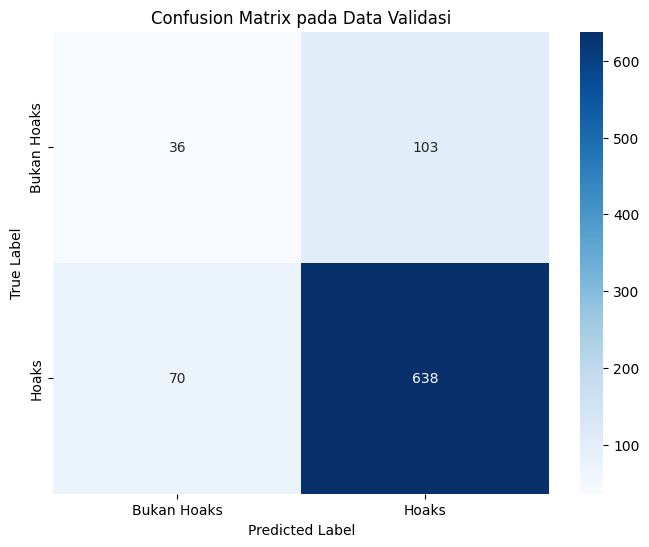

In [39]:
val_loss, val_accuracy = model.evaluate(X_val_padded, y_val_encoded)
print(f"Validation Accuracy: {val_accuracy}")

# Menampilkan Confusion Matrix
y_val_pred = (model.predict(X_val_padded) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Bukan Hoaks", "Hoaks"], yticklabels=["Bukan Hoaks", "Hoaks"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix pada Data Validasi")
plt.show()


**Menyimpan Model**

In [40]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("hoax_detection_model.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved in JSON format.")

Model architecture saved in JSON format.
